# Distributed Denial Of Service Detection

## Set up dataset

### Upload Kaggle key

Update your kaggle username and password

In [ ]:
%%bash
# Update Kaggle details
export USERNAME=ahthshamali
export KEY=a7240e5533eae2891f4d3d67875dcfd3

#Check Kaggle credentials
if [ -z "$USERNAME" ]; then
    echo "Error: USERNAME is null"
    exit 1
fi

if [ -z "$KEY" ]; then
    echo "Error: KEY is null"
    exit 1
fi

# Create a JSON object
JSON="{\"username\": \"$USERNAME\", \"key\": \"$KEY\"}"

# Write the JSON object to kaggle.json
echo "$JSON" > kaggle.json
echo "Key written for $USERNAME to kaggle.json"

### Change kaggle key permissions

Owner: Read (4) + Write (2) = 6

Group: No permissions (0)

Others: No permissions (0)

In [ ]:

! mkdir -p  ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! cat ~/.kaggle/kaggle.json
! echo "Permisions Set"

### Download the dataset

Download the dataset from kaggle in preparation for cleaning

In [3]:
!kaggle datasets download -d hassan06/nslkdd

 94%|███████████████████████████████████▋  | 13.0M/13.9M [00:01<00:00, 18.4MB/s]
100%|██████████████████████████████████████| 13.9M/13.9M [00:01<00:00, 10.7MB/s]


Unzip the dataset into the working directory

In [4]:
!unzip nslkdd.zip -d nslkdd

Archive:  nslkdd.zip
  inflating: nslkdd/KDDTest+.arff    
  inflating: nslkdd/KDDTest+.txt     
  inflating: nslkdd/KDDTest-21.arff  
  inflating: nslkdd/KDDTest-21.txt   
  inflating: nslkdd/KDDTest1.jpg     
  inflating: nslkdd/KDDTrain+.arff   
  inflating: nslkdd/KDDTrain+.txt    
  inflating: nslkdd/KDDTrain+_20Percent.arff  
  inflating: nslkdd/KDDTrain+_20Percent.txt  
  inflating: nslkdd/KDDTrain1.jpg    
  inflating: nslkdd/index.html       
  inflating: nslkdd/nsl-kdd/KDDTest+.arff  
  inflating: nslkdd/nsl-kdd/KDDTest+.txt  
  inflating: nslkdd/nsl-kdd/KDDTest-21.arff  
  inflating: nslkdd/nsl-kdd/KDDTest-21.txt  
  inflating: nslkdd/nsl-kdd/KDDTest1.jpg  
  inflating: nslkdd/nsl-kdd/KDDTrain+.arff  
  inflating: nslkdd/nsl-kdd/KDDTrain+.txt  
  inflating: nslkdd/nsl-kdd/KDDTrain+_20Percent.arff  
  inflating: nslkdd/nsl-kdd/KDDTrain+_20Percent.txt  
  inflating: nslkdd/nsl-kdd/KDDTrain1.jpg  
  inflating: nslkdd/nsl-kdd/index.html  


## Import Libraries

In [5]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import itertools
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

## Import Data

In [6]:
# fetch the training file
twenty_pct_file = 'nslkdd/KDDTrain+_20Percent.txt'
training_path = 'nslkdd/KDDTrain+.txt'
test_path = 'nslkdd/KDDTest+.txt'

The dataset does not have columns, so give them column names

In [7]:
cols = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
 'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
 'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
 'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
 'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
 'dst_host_srv_rerror_rate','attack','level', ]

In [8]:
df_main = pd.read_csv(training_path, names= cols)
df_test = pd.read_csv(test_path, names= cols)
df_main.shape, df_test.shape

((125973, 43), (22544, 43))

In [9]:
df_main.drop(['level'],axis=1,inplace=True)
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-null  int64  
 13 

In [10]:
df_test.drop(['level'],axis=1,inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

In [11]:
df_main.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [12]:
df_main['attack'].value_counts()

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: attack, dtype: int64

## Data transformation
Transformations of data I'm going to create a column that encodes 'normal' values as 0 and any other value as 1. This will be our classifier in a basic binary model that identifies any assault.

In [13]:
dos = ['land', 'worm', 'back', 'udpstorm', 'smurf', 'teardrop', 'pod', 'processtable', 'neptune', 'mailbomb', 'apache2']
probes = ['nmap', 'satan', 'mscan', 'portsweep', 'ipsweep', 'saint'] 
u2r = ['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'sqlattack', 'ps', 'xterm'] # User to Root attacks
sybil = ['multihop', 'ftp_write', 'spy', 'sendmail', 'warezmaster', 'snmpguess', 'xsnoop', 'imap', 'named', 'phf', 'http_tunnel', 'warezclient', 'guess_passwd', 'xclock', 'snmpgetattack']
attack_labels = ['Normal','DoS Attack','Probe','U2R','Sybil']

In [14]:
map_attack = lambda attack: 'dos' if attack in dos else 'probes' if attack in probes else 'u2r' if attack in u2r else 'sybil' if attack in sybil else 'nornal'

In [15]:
attack_map = df_main.attack.apply(map_attack)
df_main['attack'] = attack_map

test_attack_map = df_test.attack.apply(map_attack)
df_test['attack'] = test_attack_map

df_main.attack.value_counts()

nornal    67343
dos       45927
probes    11656
sybil       995
u2r          52
Name: attack, dtype: int64

In [47]:
labels = df_main.attack.unique()
labels = list(labels)
labels

['nornal', 'dos', 'sybil', 'probes', 'u2r']

In [16]:
attack_vs_protocol = pd.crosstab(df_main.attack, df_main.protocol_type)
attack_vs_protocol

protocol_type,icmp,tcp,udp
attack,,,
dos,2847,42188,892
nornal,1309,53600,12434
probes,4135,5857,1664
sybil,0,995,0
u2r,0,49,3


### Scaling

In [17]:
multi_data = df_main.copy()
multi_label = pd.DataFrame(multi_data.attack)

In [18]:
test_multi_data = df_test.copy()

test_multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,private,REJ,0,0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,dos
1,0,tcp,private,REJ,0,0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,dos
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,nornal
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,probes
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,probes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,...,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,nornal
22540,0,tcp,http,SF,317,938,0,0,0,0,...,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,nornal
22541,0,tcp,http,SF,54540,8314,0,0,0,2,...,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,dos
22542,0,udp,domain_u,SF,42,42,0,0,0,0,...,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,nornal


In [19]:
from sklearn.preprocessing import (StandardScaler, OrdinalEncoder,LabelEncoder, MinMaxScaler, OneHotEncoder)


# using standard scaler for normalizing
std_scaler = StandardScaler()
def standardization(df,col):
  for i in col:
    arr = df[i]
    arr = np.array(arr)
    df[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return df

numeric_col = df_main.select_dtypes(include='number').columns
data = standardization(multi_data,numeric_col)

numeric_col = df_test.select_dtypes(include='number').columns
data = standardization(multi_data,numeric_col)

In [20]:
from sklearn import preprocessing

le2 = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
multi_data['attack'] = enc_label
#y_mul = multi_data['intrusion']
multi_data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,-0.110249,tcp,ftp_data,SF,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.818890,-0.782367,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,1
1,-0.110249,udp,other,SF,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-1.035688,-1.161030,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,1
2,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.809857,-0.938287,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0
3,-0.110249,tcp,http,SF,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,...,1.258754,1.066401,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,1
4,-0.110249,tcp,http,SF,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,...,1.258754,1.066401,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.110249,tcp,private,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.818890,-0.938287,-0.121485,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0
125969,-0.107178,udp,private,SF,-0.007744,-0.004883,-0.014089,-0.089486,-0.007736,-0.095076,...,1.159389,0.977304,-0.386146,-0.447834,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,1
125970,-0.110249,tcp,smtp,SF,-0.007382,-0.004823,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.773724,-0.893738,-0.121485,-0.480197,-0.289103,0.979238,-0.624871,-0.355014,-0.376387,1
125971,-0.110249,tcp,klogin,S0,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,...,-0.972455,-1.094207,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,0


## Visualisation

The function named `bake_pies` helps visualize data using pie charts. This function takes a list of data sets and their corresponding labels as input and generates pie charts for each data set.


In [21]:
def bake_pies(data_list, labels):
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    fig, axs = plt.subplots(1, len(data_list), figsize=(18, 10), tight_layout=False)
    plt.subplots_adjust(wspace=1 / len(data_list))
    
    for ax, (data_set, label) in zip(axs, zip(data_list, labels)):
        unique_values = np.unique(data_set.index)
        cdict.update({value: next(color_cycle) for value in unique_values if value not in cdict})
        
        wedges, texts = ax.pie(data_set, colors=[cdict[v] for v in data_set.index])
        
        ax.legend(wedges, data_set.index, title="Flags", loc="lower left", bbox_to_anchor=(1, 0, 0.5, 1))
        ax.set_title(label)
        
    return axs

Visualizing the distribution of attack types based on different network protocols using pie charts.

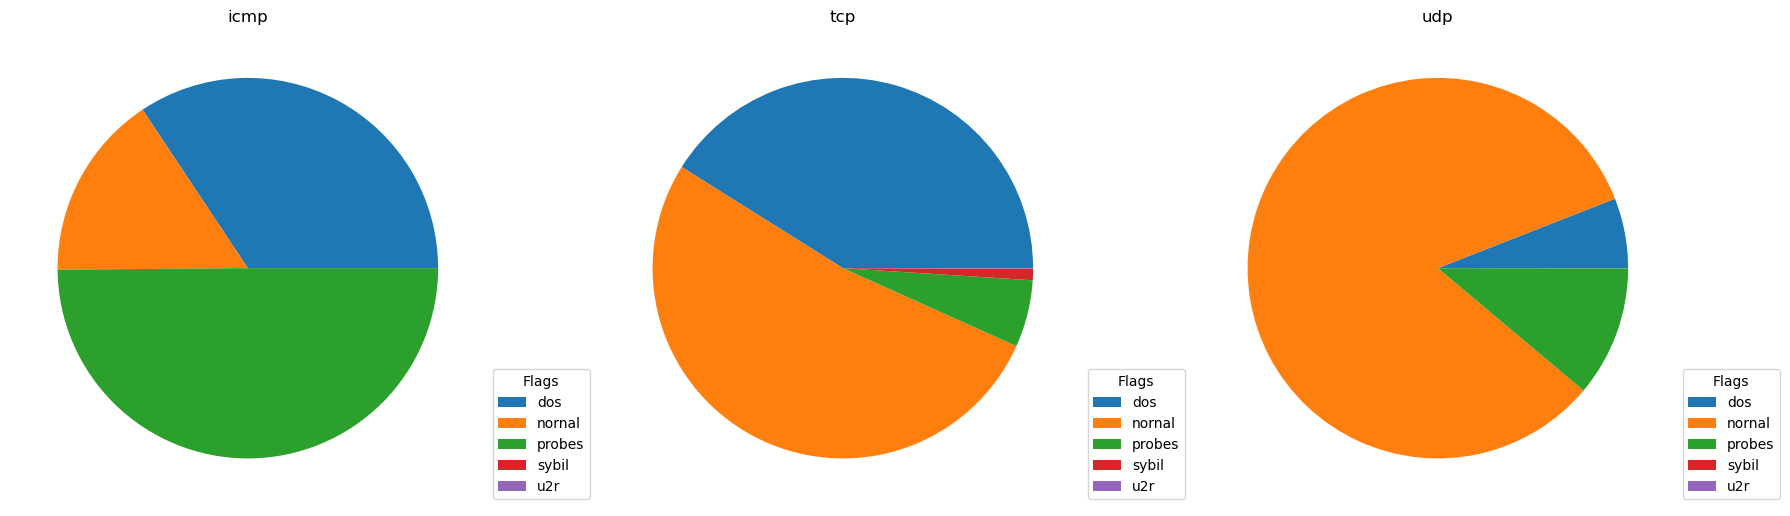

In [22]:
attacks = [attack_vs_protocol.icmp, attack_vs_protocol.tcp,attack_vs_protocol.udp ]

bake_pies(attacks,['icmp','tcp','udp'])
plt.show()

The monitoring technique employs a variety of continuous network protocols capable of understanding the small differences between threats and lawful ones. Sybil and other attacks (ddos, probing, u2r) are classified using historical data given into a machine learning model. It aids in identifying repeated patterns of Sybil, DDoS, U2R, and Probe assaults as well as locating them in the long-term traffic chain.

## Feature Engineering
Feature engineering is a crucial aspect of the data preprocessing phase in machine learning and data analysis. It involves creating new features or modifying existing ones from your raw data to improve the performance of your machine learning models or to enhance the insights you can derive from your data.

### One hot encoding

In [23]:
# one-hot-encoding attack label
multi_data = pd.get_dummies(multi_data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")  
multi_data

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
0,-0.110249,-0.007679,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0,0,0,0,0,0,0,0,1,0
1,-0.110249,-0.007737,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0,0,0,0,0,0,0,0,1,0
2,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0,0,0,0,1,0,0,0,0,0
3,-0.110249,-0.007723,-0.002891,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,0,0,0,0,0,0,0,0,1,0
4,-0.110249,-0.007728,-0.004814,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0,0,0,0,1,0,0,0,0,0
125969,-0.107178,-0.007744,-0.004883,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0,0,0,0,0,0,0,0,1,0
125970,-0.110249,-0.007382,-0.004823,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,1.235694,-0.011664,...,0,0,0,0,0,0,0,0,1,0
125971,-0.110249,-0.007762,-0.004919,-0.014089,-0.089486,-0.007736,-0.095076,-0.027023,-0.809262,-0.011664,...,0,0,0,0,1,0,0,0,0,0


In [24]:
# one-hot-encoding attack label
test_multi_data = pd.get_dummies(test_multi_data,columns=['protocol_type','service','flag'],prefix="",prefix_sep="")  
test_multi_data

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,REJ,RSTO,RSTOS0,RSTR,S0,S1,S2,S3,SF,SH
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,15,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,794,333,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
22540,0,317,938,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
22541,0,54540,8314,0,0,0,2,0,1,1,...,0,0,0,0,0,0,0,0,1,0
22542,0,42,42,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


### Train test split

Prepare the data for both binary and multi-class classification tasks. We will split the dataset into training and validation sets for both classification tasks.


In [25]:
y_train_multi= multi_data[['attack']]
X_train_multi= multi_data.drop(labels=['attack'], axis=1)

print('X_train has shape:',X_train_multi.shape,'\ny_train has shape:',y_train_multi.shape)

X_train has shape: (125973, 122) 
y_train has shape: (125973, 1)


In [26]:
y_test_multi= test_multi_data[['attack']]
X_test_multi= test_multi_data.drop(labels=['attack'], axis=1)

print('X_train has shape:',X_test_multi.shape,'\ny_train has shape:',y_test_multi.shape)

X_train has shape: (22544, 116) 
y_train has shape: (22544, 1)


In [27]:
y_train_multi['attack'].value_counts()

1    67343
0    45927
2    11656
3      995
4       52
Name: attack, dtype: int64

In [28]:
from sklearn.preprocessing import LabelBinarizer

y_train_multi = LabelBinarizer().fit_transform(y_train_multi)
y_train_multi

array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [29]:

y_test_multi = LabelBinarizer().fit_transform(y_test_multi)
y_test_multi

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0]])

In [30]:
X_train_multi=np.array(X_train_multi)
y_train_multi=np.array(y_train_multi)

# splitting the dataset 80% for training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_train_multi,y_train_multi, test_size=0.20, random_state=42)
X_train.shape

(100778, 122)

In [31]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(100778, 122, 1)

In [32]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(25195, 122, 1)

Neural network architecture suitable for the deep learning. We will define and compile a deep learning model for binary classification using the Keras library. The model architecture will consist of multiple layers, including input, hidden, and output layers.

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Dropout

input_shape = (X_train.shape[1], 1)  # Input shape with one channel

def new_model():
    model = Sequential() 
    # with 50 neurons
    model.add(Conv1D(32, 3, padding="same",input_shape = input_shape, activation='relu'))
    model.add(MaxPool1D(pool_size=(4)))  
    model.add(Dropout(0.2))
    model.add(Conv1D(32, 3, padding="same", activation='relu'))
    model.add(MaxPool1D(pool_size=(4)))  
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(units=50))
    # softmax activation
    model.add(Dense(units=5,activation='softmax'))
    # Compile the model

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    
model = new_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 122, 32)           128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 30, 32)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 32)            3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 32)            0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 7, 32)             0

In this section, we will train our deep learning model using the training data while also validating its performance on the validation dataset. This approach helps us monitor the model's progress and prevent overfitting by observing its performance on data it hasn't been directly trained on.


In [34]:
# training the model on training dataset
history = model.fit(X_train, y_train, epochs=100, batch_size=5000,validation_split=0.2)

Epoch 1/100
17/17 [==============================] - 7s 318ms/step - loss: 1.0949 - accuracy: 0.6446 - val_loss: 0.8057 - val_accuracy: 0.7763
Epoch 2/100
17/17 [==============================] - 5s 301ms/step - loss: 0.7113 - accuracy: 0.7821 - val_loss: 0.5073 - val_accuracy: 0.8552
Epoch 3/100
17/17 [==============================] - 5s 322ms/step - loss: 0.4662 - accuracy: 0.8566 - val_loss: 0.3059 - val_accuracy: 0.9206
Epoch 4/100
17/17 [==============================] - 5s 299ms/step - loss: 0.3225 - accuracy: 0.9049 - val_loss: 0.2179 - val_accuracy: 0.9467
Epoch 5/100
17/17 [==============================] - 5s 295ms/step - loss: 0.2583 - accuracy: 0.9247 - val_loss: 0.1867 - val_accuracy: 0.9512
Epoch 6/100
17/17 [==============================] - 5s 296ms/step - loss: 0.2249 - accuracy: 0.9341 - val_loss: 0.1666 - val_accuracy: 0.9566
Epoch 7/100
17/17 [==============================] - 5s 300ms/step - loss: 0.2032 - accuracy: 0.9414 - val_loss: 0.1521 - val_accuracy: 0.9603

In [35]:
model.save("ddos_detector.h5")

In [36]:
# from tensorflow.contrib import lite
# converter = lite.TFLiteConverter.from_keras_model_file( 'ddos_detector.h5')
# tfmodel = converter.convert()
# open ("model.tflite" , "wb") .write(tfmodel)

### Model evaluation on Validation set


In this section, we will evaluate the performance of our deep learning model on the validation dataset. We will calculate the validation loss and validation accuracy to assess how well the model performs on data it hasn't seen during training.


In [37]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

788/788 [==============================] - 2s 3ms/step - loss: 0.0429 - accuracy: 0.9867
Validation Loss: 0.0429, Validation Accuracy: 0.9867


### Accuracy vs Epoch

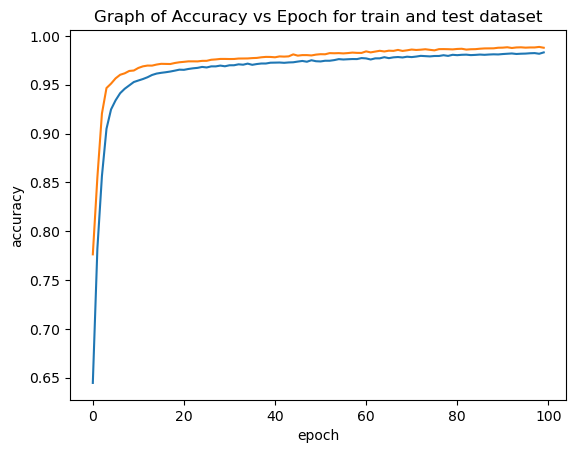

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Graph of Accuracy vs Epoch for train and test dataset")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

### Plot of loss vs epoch for train and test dataset


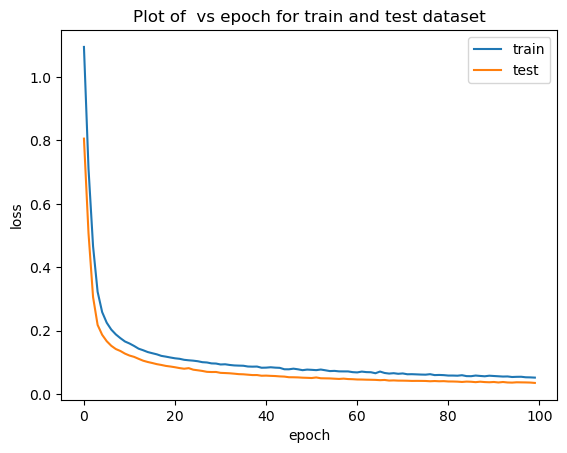

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of  vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### F1 Score, Precision, Recall

In [42]:
from sklearn.metrics import classification_report

y_test_arg = np.argmax(y_test,axis=1)
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test_arg, y_pred_bool))

394/394 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9181
           1       0.99      0.99      0.99     13422
           2       0.97      0.96      0.97      2357
           3       0.91      0.58      0.71       224
           4       0.60      0.27      0.37        11

    accuracy                           0.99     25195
   macro avg       0.89      0.76      0.81     25195
weighted avg       0.99      0.99      0.99     25195



### Confusion matrix

Confusion Matrix


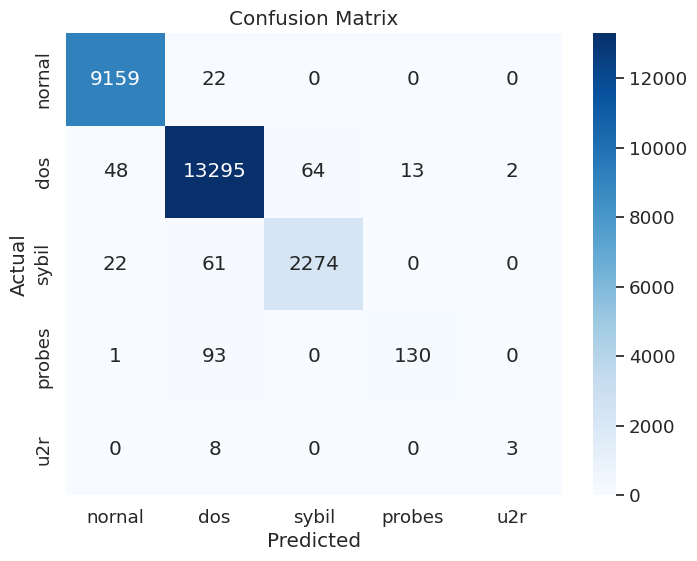

In [50]:
print('Confusion Matrix')
matrix = confusion_matrix(y_test_arg, y_pred_bool)

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()